# Cannabis legalization effects on hard drugs trafficking and usage
#### By Nardine Abu-Nassar and Arie Stoliarsky

---

# Data preprocessing
## Scope and overview of the Drug-Policy domain

#### Population
We define a sample of the population as a **country's status at a period of a year**, i.e. a country's legal, economical and drug related felonies aggregated by a single year.
There are 201 countries with data over the years 2018-2022, which makes our population's size 1005 instances.

#### Variables
<u>The following is a list of **input variables**</u>:
- country (name): textual/categorical value. Contains 201 possible values.
- region: textual/categorical value. Contains the following values:
    - Europe
    - Africa
    - Asia
    - Oceania
    - North America
    - Central America
    - South America
- cannabis legalization status: categorical value. Contains the following values (will be discussed further in the lgalization processing notebook):
    - LGL
    - MED
    - DEC
    - ILL
- decriminalization maximal possession amount: numerical/continuous values (analysis in the lgalization processing notebook)
- population: number of citizens living in the country in the year in question: numerical/continuous value. This value will also acts as normalization value for other variables
- border length: numerical continuous values:
    - Divided into two categories - land border length in kilometers and shoreline length in kilometers. These variables may correlate with the amount of drug smuggling. It's also somewhat static data, since unless we factor major land exchanges, that didn't really happen in the selected timeline, it's going to be true throughout the years we explore.
- GDP: numerical/continuous value. Indicates economical strength, wealth and stability. Will be normalized per capita.
- Health budget: numerical/continuous value. Whenever possible, a country's health ministry's budget will be reported (in USD$), which could indicate how much the countries prioritize healthcare for its citizens, including combating implications of drug usage. Will be normalized by population.
- <u>Treatment cases in the population</u>: <b>This is our target variable</b>. This numerical value indicates what portion of citizens of a country (the number of cases normalized by population) are being treated for drug use by the healthcare system.
<br><br>
We hopefully could try to couple treatment statistics with policy changes and see the effect in usage of illicit drugs across time. We hypothesize that full legalization might lower hard drug use because of the legal alternative.


In [1]:
import random
import pandas as pd
import numpy as np
import os
from pathlib import Path


from utils import vis_utils
import utils.dataset_processing_utils as dputil
from utils.dataset_processing_utils import print_discrepancies

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

#### load the datasets

---

1) Download files:<BR>1.1) From the [UNODC site](https://www.unodc.org/unodc/en/data-and-analysis/wdr2024-annex.html):<BR>
    &emsp;&emsp;1.1.a) 7.1._Drug_seizures_2018-2022.xlsx<BR>
    &emsp;&emsp;1.1.b) 10.1._Drug_related_crimes.xlsx<BR>
    &emsp;&emsp;1.1.c) 5.1_Treatment_by_primary_drug_of_use.xlsx<BR>
    &emsp;1.2) From Kaggle download the [legalization status dataset](https://www.kaggle.com/datasets/venusrosario/legality-of-cannabis/)     <BR>
    &emsp;1.3) Also from Kaggle download the [CIA FactBook data](https://www.kaggle.com/datasets/lucafrance/the-world-factbook-by-cia)     <BR>
    &emsp;1.4) From the WorldBankGroup website, we arranged the collected the data in the timescale we require and exported it into wbg_pop_health_gdp.csv<BR>

2) Change the names for our ease of use:<BR>
    &emsp;2.1) 7.1._Drug_seizures_2018-2022.xlsx --> unodc_drug_seizures.xlsx<BR>
    &emsp;2.2) 10.1._Drug_related_crimes.xlsx --> unodc_drug_crime_counts.xlsx<BR>
    &emsp;2.3) 5.1_Treatment_by_primary_drug_of_use.xlsx --> unodc_drug_treatment.xlsx<BR>
    &emsp;2.3) Legality_of_cannabis.csv --> legalization.csv<BR>

3) Manual feature engineering - further explanation in [here](#manual-feature-engineering)

4) Load data into pandas Dataframes


In [2]:
# Defining constants
if os.name == 'nt':  # in case of MS Windows
    data_path = Path(f"{os.getcwd()}\\data\\")
else:  # Linux or Mac
    data_path = Path(f"{os.getcwd()}/data/")

# rename dataset files
dputil.rename_original_dataset_files(data_path)


In [3]:
# load into pandas DataFrame:
seizures_df = dputil.load_dataset('unodc_drug_seizures.xlsx')
seizures_df.head()

,Region,SubRegion,Country,DrugGroup,DrugSubGroup,DrugName,Reference year,Kilograms,msCode
0,Africa,East Africa,Kenya,Amphetamine-type stimulants (excluding “ecstasy”),Methamphetamine,Methamphetamine,2022,10.84,KEN
1,Africa,East Africa,Kenya,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),Cannabis herb (marijuana),2022,8474.41,KEN
2,Africa,East Africa,Kenya,Cannabis-type drugs (excluding synthetic canna...,Cannabis plants,Cannabis plants,2022,2534.40,KEN
3,Africa,East Africa,Kenya,Cocaine-type,Cocaine,Cocaine hydrochloride,2022,10.99,KEN
4,Africa,East Africa,Kenya,Opioids,Opiates,Heroin,2022,38.94,KEN


In [4]:
crime_counts_df = dputil.load_dataset('unodc_drug_crime_counts.xlsx')
crime_counts_df.head()

,Africa,West and Central Africa,Ghana,ARQ2021,2021,Other drug-related offences,Any Illicit drugs,0,Unnamed: 8,Unnamed: 9,Unnamed: 10,0.1,0.2,Unnamed: 13,Unnamed: 14,Yes,Yes.1,GHA
0,Europe,Western and Central Europe,Gibraltar,ARQ2021,2021,Other drug-related offences,Any Illicit drugs,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,GIB
1,Asia,East and South-East Asia,"China, Macao SAR",ARQ2021,2021,Other drug-related offences,Any Illicit drugs,0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,Yes,Yes,MAC
2,Americas,South America,Venezuela (Bolivarian Republic of),ARQ2022,2022,Other drug-related offences,Any Illicit drugs,0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,Yes,Yes,VEN
3,Africa,North Africa,Algeria,HIST2018,2018,Offences related to drug trafficking,Other opioids not under international control,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Yes,DZA
4,Europe,Western and Central Europe,Gibraltar,ARQ2020,2020,Other drug-related offences,Any Illicit drugs,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Yes,Yes,GIB


In [5]:
treatments_df = dputil.load_dataset('unodc_drug_treatment.xlsx')
treatments_df.head()

,Region,SubRegion,Country,msCode,Reference year,DrugGroup,Drug,Sex,Value,Campaign,Coverage
0,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamines (amphetamine/methamphetamine),Females,2,ARQ2021,NaN
1,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamines (amphetamine/methamphetamine),Males,2,ARQ2021,NaN
2,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamines (amphetamine/methamphetamine),Total,4,ARQ2021,NaN
3,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamine-type stimulants,Females,8,ARQ2021,NaN
4,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamine-type stimulants,Males,81,ARQ2021,NaN


In [6]:
legalization_df = dputil.load_dataset('legalization.csv', encoding='utf-16')
legalization_df.head()

,Country/Territory,Recreational,Recreational_year,Medical,Mediacal_year,Decriminalized_max_possession,Notes
0,Afghanistan,Illegal,NaN,Illegal,NaN,NaN,Production banned by King Zahir Shah in 1973.
1,Albania,Illegal,NaN,Legal,2023.0,NaN,Prohibited but plants highly available through...
2,Algeria,Illegal,NaN,Illegal,NaN,NaN,NaN
3,Andorra,Illegal,NaN,Illegal,NaN,NaN,NaN
4,Angola,Illegal,NaN,Illegal,NaN,NaN,NaN


In [7]:
borders_df = dputil.load_dataset('cia_factbook.csv', encoding='utf-8')
borders_df.head()

,Country,Geography: Land boundaries - total,Geography: Coastline
0,Afghanistan,"5,987 km",0 km (landlocked)
1,Akrotiri,NaN,NaN
2,Albania,691 km,362 km
3,Algeria,"6,734 km",998 km
4,American Samoa,0 km,116 km


In [8]:
demographics_df = dputil.load_dataset('wbg_pop_health_gdp.csv', encoding='latin-1')
demographics_df.head()

,Country Name,Country Code,Series Name,Series Code,2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024],Unnamed: 12,Unnamed: 13
0,Afghanistan,AFG,"Population, total",SP.POP.TOTL,35688935,36743039,37856121,39068979,40000412,40578842,41454761,..,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,18753456498,18053222687,18799444490,19955929052,14259995441,14497243872,17233051620,..,NaN,NaN
2,Afghanistan,AFG,Current health expenditure (% of GDP),SH.XPD.CHEX.GD.ZS,12.62081718,14.20841885,14.83131981,15.53361416,21.508461,23.0881691,..,..,NaN,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,2873457,2866376,2854191,2837849,2811666,2777689,2745972,..,NaN,NaN
4,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,13019726212,15379509892,15585105131,15241458745,18032010564,19017242586,23547179830,..,NaN,NaN


---

## Manual feature engineering
### legalization.csv

There was crucial information missing - the years when legislation had changed.
Therefore, using the **Notes** column, which contains diverse information, including years when countries changed legislation.
Additionally, it contains data about the maximum amount of cannabis that a citizen can have on his possession without receiving a penalty (in grams).

As such, we manually had created three new columns - *Recreational_year* (integer) and *Medical_year* (integer) which indicate the year the legislation
was enacted in, according to of our category, and *Decriminalized_max_possession* (float) that indicates the maximum amount of possession of cannabis on a person is allowed in a country (in grams).

We validated our manual work with reference to other Wikipedia pages and Google's Gemini for further consultation.

---

### cia_factbook.csv

The original CIA FactBook data had contained 980 columns. We have extracted only the necessary columns, which are the country's name, its border and shoreline length. Furthermore, although we hadn't had the time to do so, we would like to in perpetration for the final report convert the textual data for the borders into numerical data by omitting any non-numerical value from it.

---
### Initial analysis of each dataframe

In this section, we run individual data processing notebooks for each dataset. Each notebook contains data processing methods and data analysis.
You're welcome to run and read every notebook to see how the data was processed.

#### _unodc_seizures_
see notebook: `./individual_dataset_notebooks/unodc_seizures.ipynb`

In [9]:
%%capture
%run ./individual_dataset_notebooks/unodc_seizures.ipynb

#### _unodc_drug_crime_counts_

see notebook: `./individual_dataset_notebooks/unodc_drug_crime_counts.ipynb`

In [10]:
%%capture
%run ./individual_dataset_notebooks/unodc_drug_crime_counts.ipynb

#### _unodc_treatments_

see notebook: `./individual_dataset_notebooks/unodc_treatments.ipynb`

In [11]:
%%capture
%run ./individual_dataset_notebooks/unodc_treatments.ipynb

#### _wbg_pop_health_gdp_

see notebook: `./individual_dataset_notebooks/wbg_pop_health_gdp.ipynb`

In [12]:
%%capture
%run ./individual_dataset_notebooks/wbg_pop_health_gdp.ipynb

#### _cia_factbook_

see notebook: `./individual_dataset_notebooks/cia_factbook.ipynb`

In [13]:
%%capture
%run ./individual_dataset_notebooks/cia_factbook.ipynb

#### _legalization_

see notebook: `./individual_dataset_notebooks/legalization.ipynb`

In [14]:
%%capture
%run ./individual_dataset_notebooks/legalization.ipynb

---

### Merging dataframes and further analysis

Now that we are done processing each dataset individually, we would want to merge them.

**Combination process**:

1) `legalization_df_sorted` + `final_seizures_df` = `merged_df`

2) `merged_df` += `edited_crime_counts_df`

3) `merged_df` += `edited_treatments_df`

4) `merged_df` += `demographics_df_edited`

5) `merged_df` += `borders_df_edited`

6) Further analysis - potential correlations, splicing etc.

<BR><BR>

---


#### merging *legalization_df_sorted* and *final_seizures_df*

**initial merging process**

In [15]:
merged_df = final_seizures_df.merge(legalization_df_sorted, on=["country"], how="outer", validate="many_to_one")

Now we'll check the countries what countries didn't align properly:

In [16]:
merged_df[pd.isna(merged_df['legal_category'])]["country"].unique()

array(['Aruba', 'Bolivia (Plurinational State of)', 'Brunei Darussalam',
       'Cabo Verde', 'China', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, Taiwan Province of China', 'Czechia', "Côte d'Ivoire",
       'Eswatini', 'Iran (Islamic Republic of)',
       "Lao People's Democratic Republic", 'Republic of Korea',
       'Republic of Moldova', 'Russian Federation', 'State of Palestine',
       'Syrian Arab Republic', 'Timor-Leste', 'Türkiye',
       'United Republic of Tanzania', 'United States of America',
       'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Zimbabwe'],
      dtype=object)

In [17]:
merged_df.query("seizure_volume.isnull() & legal_category != 'ILL'")["country"].unique()


array(['Bermuda', 'Bolivia', 'Czech Republic', 'Dominica', 'Korea, South',
       'Moldova', 'Rwanda', 'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'San Marino', 'Turkey',
       'Vanuatu'], dtype=object)

List of countries/territories that were removed due to missing values:
- <span style="color: #006400;">Aruba (missing legalization status)</span>
- <span style="color: #006400;">Palestine (missing legalization status)</span>
- <font color="green">Bermuda (missing traffic data)</font>
- <font color="green">Dominica (missing traffic data)</font>
- <font color="green">Rwanda (missing traffic data)</font>
- <font color="green">Saint Kitts and Nevis (missing traffic data)</font>
- <font color="green">Saint Lucia (missing traffic data)</font>
- <font color="green">Saint Vincent and the Grenadines (missing traffic data)</font>
- <font color="green">San Marino (missing traffic data)</font>
- <font color="green">Vanuatu (missing traffic data)</font>


Countries that were added to the list after searching their cannabis legality status:
- Gibraltar (ILL)
- Armenia (ILL)


Additionally - we have changed the names of some countries in order to merge the two datasets correctly. We arbitrarily decided to change the names in  *seizure_df*:

| Old name | New name |
| --- | --- |
| Bolivia (Plurinational State of) | Bolivia |
| Brunei Darussalam | Brunei |
| Cabo Verde | Cape Verde |
| China | People's Republic of China (PRC) |
| China, Hong Kong SAR | Hong Kong |
| China, Macau SAR | Macau, SAR of China |
| China, Taiwan Province of China | Taiwan |
| Czechia | Czech Republic |
| Côte d'Ivoire | Ivory Coast |
| Eswatini | Eswatini (Swaziland) |
| Iran (Islamic Republic of) | Iran |
| Lao People's Democratic Republic | Laos |
| Republic of Korea | Korea, South |
| Republic of Moldova | Moldova |
| Russian Federation | Russia |
| Syrian Arab Republic | Syria |
| Timor-Leste | East Timor |
| Türkiye | Turkey |
| United Republic of Tanzania | Tanzania |
| United States of America | United States |
| Venezuela (Bolivarian Republic of) | Venezuela |

In [18]:
country_names_to_change = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Brunei Darussalam": "Brunei",
    "Cabo Verde": "Cape Verde",
    "China": "People's Republic of China (PRC)",
    "China, Hong Kong SAR": "Hong Kong",
    "China, Macau SAR": "Macau, SAR of China",
    "China, Macao SAR": "Macau, SAR of China",  # there are 2 variations
    "China, Taiwan Province of China": "Taiwan",
    "Czechia": "Czech Republic",
    "Côte d'Ivoire": "Ivory Coast",
    "Eswatini": "Eswatini (Swaziland)",
    "Holy See": "Vatican City",
    "Iran (Islamic Republic of)": "Iran",
    "Lao People's Democratic Republic": "Laos",
    "Republic of Korea": "Korea, South",
    "Republic of Moldova": "Moldova",
    "Russian Federation": "Russia",
    "Syrian Arab Republic": "Syria",
    "Timor-Leste": "East Timor",
    "Türkiye": "Turkey",
    "United Republic of Tanzania": "Tanzania",
    "United States of America": "United States",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Viet Nam": "Vietnam"
}

In [19]:
final_seizures_df['country'] = final_seizures_df['country'].replace(country_names_to_change)

rows_to_add_to_legalization_df = [
    {"country": "Armenia", "legal_category": "ILL"},
    {"country": "Gibraltar", "legal_category": "ILL"},
]

legalization_df_sorted = pd.concat([legalization_df_sorted, pd.DataFrame(data=rows_to_add_to_legalization_df, columns=legalization_df_sorted.columns)], ignore_index=True)

Repeating the merge sequence after our changes. By using an inner join matching mechanism, we remove all territories with missing information as mentioned above.

In [20]:
merged_df = final_seizures_df.merge(legalization_df_sorted, on=["country"], how="inner")
merged_df.sample(10, random_state=SEED).sort_values("legal_category")

,region,country,drug_group,drug_sub_group,seizure_reference_year,seizure_volume,legal_category,recreational_year,medical_year,decriminalized_max_possession
3148,Europe,Estonia,Cannabis-type drugs (excluding synthetic canna...,Cannabis seed,2022,0.00021,DEC,NaN,NaN,7.5
1073,Asia,People's Republic of China (PRC),Sedatives and tranquillizers,Reported total sedatives and tranquillizers,2022,81.50000,ILL,NaN,NaN,NaN
5304,North America,United States,Hallucinogens,LSD,2022,30.00000,ILL,NaN,NaN,NaN
1321,Asia,India,Sedatives and tranquillizers,Benzodiazepines,2021,9.09524,ILL,NaN,NaN,NaN
5955,South America,Venezuela,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2021,6016.47500,ILL,NaN,NaN,20.0
1720,Asia,Malaysia,Opioids,Opiates,2018,1441.00000,ILL,NaN,NaN,NaN
2157,Asia,Thailand,Opioids,Opiates,2020,2299.49405,LGL,2022.0,2018.0,NaN
5466,Oceania,New Zealand,Cannabis-type drugs (excluding synthetic canna...,Cannabis plants,2018,4543.00000,MED,NaN,2018.0,27.0
5011,Europe,Turkey,“Ecstasy”-type substances,“Ecstasy”-type substances,2018,2279.00000,MED,NaN,2016.0,NaN
4378,Europe,Romania,Cannabis-type drugs (excluding synthetic canna...,Cannabis oil,2022,0.22048,MED,NaN,2013.0,NaN


---

#### adding *edited_crime_counts_df*

**analyze difference in columns before merge**

In [21]:
edited_crime_counts_df.columns

Index(['region', 'sub_region', 'country', 'year', 'offence_type', 'drug_group',
       'calculated_total', 'crime_count_gender_ratio'],
      dtype='object')

In [22]:
merged_df.columns

Index(['region', 'country', 'drug_group', 'drug_sub_group',
       'seizure_reference_year', 'seizure_volume', 'legal_category',
       'recreational_year', 'medical_year', 'decriminalized_max_possession'],
      dtype='object')

In [23]:
# region:
dputil.print_discrepancies(merged_df, edited_crime_counts_df, "region", "region")

columns region and region in dataframes are the same!


In [24]:
# country:
dputil.print_discrepancies(merged_df, edited_crime_counts_df, "country", "country")

missing values from df1.country: {'United States', 'Korea, South', 'Bolivia', 'Bahrain', 'Eswatini (Swaziland)', 'Iran', 'Sudan', 'Kuwait', 'Moldova', 'Mauritania', 'Laos', 'Brunei', 'Dominican Republic', 'Guyana', 'Guinea', 'Barbados', 'East Timor', 'Venezuela', 'Seychelles', 'Jamaica', 'Tanzania', 'Angola', 'Syria', 'Libya', 'Belize', 'Cameroon', 'Norway', 'Hong Kong', 'Antigua and Barbuda', 'Macau, SAR of China', 'Taiwan', 'Madagascar', 'Georgia', 'Cape Verde', 'Russia', 'Vietnam', 'Maldives', 'Turkey', 'United Arab Emirates', 'Azerbaijan', 'Czech Republic', 'Liberia', 'Ivory Coast', 'Afghanistan', 'Jordan', "People's Republic of China (PRC)", 'Chad'}


missing values from df2.country: {'Syrian Arab Republic', 'Brunei Darussalam', 'Republic of Moldova', 'Republic of Korea', 'United States of America', 'Iran (Islamic Republic of)', 'Czechia', 'State of Palestine', 'Bolivia (Plurinational State of)', 'Holy See', 'Türkiye', 'Viet Nam', 'China', 'Russian Federation', "Côte d'Ivoire", 'C

In [25]:
# fix discrepancies in country names
crime_counts_df_for_merge = edited_crime_counts_df.copy()
crime_counts_df_for_merge['country'] = crime_counts_df_for_merge['country'].replace(country_names_to_change)


In [26]:
# year
dputil.print_discrepancies(merged_df, edited_crime_counts_df, "seizure_reference_year", "year")

columns seizure_reference_year and year in dataframes are the same!


In [27]:
# drug_group
dputil.print_discrepancies(merged_df, edited_crime_counts_df, "drug_group", "drug_group")

missing values from df1.drug_group: {'Cannabis-type drugs (excluding synthetic cannabinoids)', '“Ecstasy”-type substances', 'Amphetamine-type stimulants (excluding “ecstasy”)'}


missing values from df2.drug_group: {'Methamphetamine', 'Other types of cannabis', 'Other Plant-based substances', 'Other substances not under int. control', 'Any Illicit drugs', 'Pharmaceutical opioids', 'Benzodiazepines', 'Plant-based NPS', 'Non-specified substances not under int. control', 'Crack', 'Cannabis oil', 'GHB', 'Ketamine and phencyclidine-type substances', 'Coca paste/cocaine base', 'Heroin', 'Other miscellaneous', 'ATS', 'Synthetic cathinones', 'Multiple Drugs', 'Marijuana (herb)', 'Other opioids not under international control', 'GBL', 'Hashish (resin)', 'Other NPS', 'Solvents and inhalants', 'Non-specified', 'Cannabis-type', 'Ecstasy-type substances', 'Other stimulants'}


Since there are too many discrepancies, we will check for the possibility of removing all `drug_group` that are not `Any Illict Drug` which exists for all countries in all years:

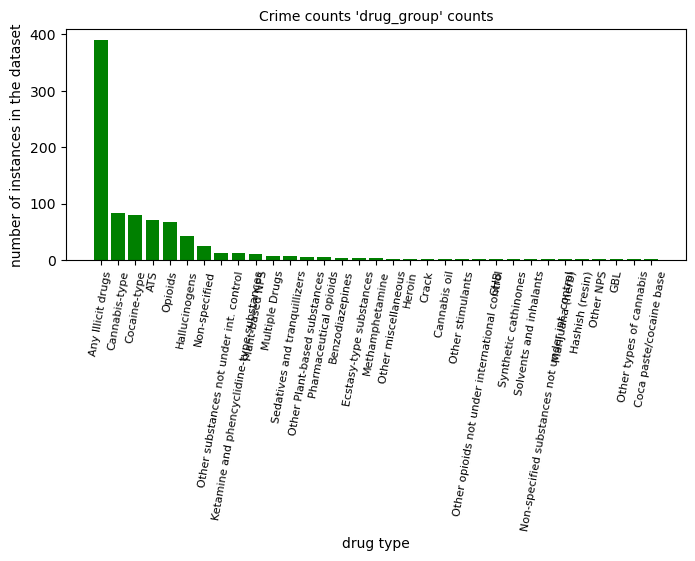

In [28]:
drug_group_instances = {}
for country_year, group in edited_crime_counts_df.groupby(['country', 'year']):
    for drug_group in group['drug_group'].unique():
        if drug_group not in drug_group_instances:
            drug_group_instances[drug_group] = 1
        else:
            drug_group_instances[drug_group] += 1

drug_group_instances = dict(sorted(drug_group_instances.items(), key=lambda x: x[1], reverse=True))

vis_utils.plot_regular_barplot(list(drug_group_instances.keys()), list(drug_group_instances.values()),
                               title="Crime counts 'drug_group' counts", xlabel="drug type", ylabel="number of instances in the dataset", color='green', xticks_rotation=80, figsize=(8, 3), xticks_fontsize=8
                               )

as we can see from the barchart above, even the 2nd highest value after *Any Illicit Drugs* - *Cannabis Type*, is far less abundant than what is required to merge the datasets correctly. Therefore, we will now filter out all non *Any Illicit Drugs* category, and remove the feature.

Additionally, we will re

#### merge dataframes

In [29]:
crime_counts_df_for_merge = crime_counts_df_for_merge[edited_crime_counts_df['drug_group'] == 'Any Illicit drugs']
crime_counts_df_for_merge.drop(columns=['drug_group', 'sub_region'], inplace=True)
crime_counts_df_for_merge = crime_counts_df_for_merge.rename(columns={"year": "drug_crime_ref_year",
                                                                "calculated_total": "total_crime_cases"})

In [30]:
merged_df = pd.merge(merged_df, crime_counts_df_for_merge, how="left", left_on=["region", "country", "seizure_reference_year"], right_on=["region", "country", "drug_crime_ref_year"])
merged_df = merged_df.drop(columns=["drug_crime_ref_year"])

---

#### adding *treatments_df*

**analyze difference in columns before merge**

In [31]:
print(f"{'*'*22}  merged_df  {'*'*22}", merged_df.columns)
print(f"{'*'*22}  treatments_df  {'*'*22}", edited_treatments_df.columns)

**********************  merged_df  ********************** Index(['region', 'country', 'drug_group', 'drug_sub_group',
       'seizure_reference_year', 'seizure_volume', 'legal_category',
       'recreational_year', 'medical_year', 'decriminalized_max_possession',
       'offence_type', 'total_crime_cases', 'crime_count_gender_ratio'],
      dtype='object')
**********************  treatments_df  ********************** Index(['country', 'year', 'drug_group', 'total_treatments', 'gender_ratio'], dtype='object')


Check for discrepancies in the following columns:
- country
- drug_group
- drug_sub_group

In [32]:
dputil.print_discrepancies(merged_df, edited_treatments_df, "country", "country")

missing values from df1.country: {'Bhutan', 'United States', 'Korea, South', 'Bolivia', 'Bahrain', 'Eswatini (Swaziland)', 'Iran', 'Sudan', 'Kuwait', 'Moldova', 'Laos', 'Brunei', 'Dominican Republic', 'Guyana', 'Israel', 'Barbados', 'East Timor', 'Japan', 'Venezuela', 'Jamaica', 'Tanzania', 'Syria', 'Belize', 'Cameroon', 'Namibia', 'Qatar', 'Hong Kong', 'Macau, SAR of China', 'Canada', 'Taiwan', 'Gambia', 'Iceland', 'Cape Verde', 'Russia', 'Pakistan', 'Vietnam', 'Maldives', 'Turkey', 'Czech Republic', 'Liberia', 'Ivory Coast', 'Afghanistan', 'India', 'Guinea-Bissau', "People's Republic of China (PRC)", 'Paraguay', 'Chad'}


missing values from df2.country: {'Brunei Darussalam', 'China', 'Venezuela (Bolivarian Republic of)', 'Russian Federation', 'Iran (Islamic Republic of)', "Côte d'Ivoire", 'Republic of Moldova', 'China, Hong Kong SAR', 'Cabo Verde', 'Holy See', 'Türkiye', 'United Republic of Tanzania', 'China, Macao SAR', "Lao People's Democratic Republic", 'Czechia', 'United States 

In [33]:
 # fix discrepancies in country names
treatments_df_for_merge = edited_treatments_df.copy()
treatments_df_for_merge['country'] = treatments_df_for_merge['country'].replace(country_names_to_change)

In [34]:
dputil.print_discrepancies(merged_df, treatments_df_for_merge, "country", "country")

missing values from df1.country: {'Bhutan', 'Korea, South', 'Bolivia', 'Bahrain', 'Eswatini (Swaziland)', 'Sudan', 'Kuwait', 'Dominican Republic', 'Guyana', 'Israel', 'Barbados', 'East Timor', 'Japan', 'Jamaica', 'Syria', 'Belize', 'Cameroon', 'Namibia', 'Qatar', 'Canada', 'Taiwan', 'Gambia', 'Iceland', 'Pakistan', 'Vietnam', 'Maldives', 'Liberia', 'Afghanistan', 'India', 'Guinea-Bissau', 'Paraguay', 'Chad'}


missing values from df2.country: {'Vatican City'}


In [35]:
missing_countries_in_treatments = {'Maldives', 'Jamaica', 'Paraguay', 'India', 'Syria', 'Barbados', 'Sudan', 'Canada', 'Japan', 'Cameroon', 'Guyana', 'Liberia', 'Belize', 'East Timor', 'Bahrain', 'Korea, South', 'Gambia', 'Pakistan', 'Afghanistan', 'Eswatini (Swaziland)', 'Israel', 'Vietnam', 'Bhutan', 'Namibia', 'Taiwan', 'Kuwait', 'Guinea-Bissau', 'Dominican Republic', 'Iceland', 'Qatar', 'Chad', 'Bolivia'}
merged_df.query("country in @missing_countries_in_treatments")[["country", "legal_category"]].drop_duplicates()["legal_category"].value_counts()

legal_category
ILL    23
MED     5
DEC     3
LGL     1
Name: count, dtype: int64

However unfortunate, we are unable to apply models and further analyses on the countries above, since we are missing our target variable.

In [36]:
dputil.print_discrepancies(merged_df, treatments_df_for_merge, "drug_group", "drug_group")

missing values from df1.drug_group: {'Cocaine-type', 'Amphetamine-type stimulants (excluding “ecstasy”)', 'Opioids', 'Cannabis-type drugs (excluding synthetic cannabinoids)', 'Sedatives and tranquillizers'}


missing values from df2.drug_group: {'Solvents and inhalants', 'Cannabis-type drugs', 'Non-medical use of pharmaceutical sedatives and tranquillizers', 'Opioids, including opiates and synthetic opioids', 'Any drug', 'Other miscellaneous', 'Non-specified', 'Amphetamine-type stimulants', 'Cocaine-type drugs', 'Other drugs / psychoactive substances / pharmaceutical products not listed above', 'New psychoactive substances', 'Substances not under international control'}


In [37]:
# align drug_group between treatments and the merged data:
drug_group_mapping_treatments = {
    'Cocaine-type drugs': 'Cocaine-type',
    'Amphetamine-type stimulants': 'Amphetamine-type stimulants (excluding “ecstasy”)',
    'Non-medical use of pharmaceutical sedatives and tranquillizers': 'Sedatives and tranquillizers',
    'Opioids, including opiates and synthetic opioids': 'Opioids',
    'Cannabis-type drugs': 'Cannabis-type drugs (excluding synthetic cannabinoids)',
    'New psychoactive substances': np.nan,
    'Non-specified': np.nan,
    'Other drugs / psychoactive substances / pharmaceutical products not listed above': np.nan,
    'Solvents and inhalants': np.nan,
    'Other miscellaneous': np.nan,
    'Any drug': np.nan,
    'Substances not under international control': np.nan
}

treatments_df_for_merge['drug_group'] = treatments_df_for_merge['drug_group'].replace(drug_group_mapping_treatments)
treatments_df_for_merge = treatments_df_for_merge.dropna(subset=['drug_group'])
treatments_df_for_merge = treatments_df_for_merge.rename(columns={"gender_ratio": "patient_gender_ratio"})

In [38]:
merged_df = pd.merge(merged_df, treatments_df_for_merge, how="inner", left_on=["country", "seizure_reference_year", "drug_group"], right_on=["country", "year", "drug_group"])
merged_df = merged_df.drop(columns=["year"])

#### Merging demographics data

In [39]:
pivoted_demographics_df.columns

Index(['country', 'Country Code', 'year', 'gdp', 'health_expenditure',
       'population', 'gdp_per_capita'],
      dtype='object', name='Series Name')

In [40]:
dputil.print_discrepancies(merged_df, pivoted_demographics_df, "country", "country")

missing values from df1.country: {'Zambia', 'Russia', 'Laos', 'Brunei', 'Slovakia', 'Egypt', 'Turkey', 'Czech Republic', 'Hong Kong', 'Macau, SAR of China', 'Venezuela', 'Kyrgyzstan', 'Bahamas', "People's Republic of China (PRC)"}


missing values from df2.country: {'Bhutan', 'Vanuatu', 'Bahrain', 'Curacao', 'Djibouti', 'Mauritania', 'Greenland', 'Dominican Republic', 'Argentina', 'Nauru', 'St. Lucia', 'Bahamas, The', 'San Marino', 'Marshall Islands', 'Dominica', 'Northern Mariana Islands', 'Micronesia, Fed. Sts.', 'Russian Federation', 'St. Vincent and the Grenadines', 'Tonga', 'Samoa', 'Liberia', 'Afghanistan', 'Kosovo', 'Syrian Arab Republic', 'Brunei Darussalam', 'Nepal', "Cote d'Ivoire", 'Bolivia', 'St. Kitts and Nevis', 'Turks and Caicos Islands', 'French Polynesia', 'Uganda', 'Sao Tome and Principe', 'American Samoa', 'Burundi', 'Macao SAR, China', 'Czechia', 'Cameroon', 'Namibia', 'Isle of Man', 'Cuba', 'Qatar', 'Congo, Rep.', 'Solomon Islands', 'Grenada', 'Kyrgyz Republic', 'S

In [41]:
demographics_df_for_merge = pivoted_demographics_df.copy()
demographics_df_for_merge["country"] = demographics_df_for_merge["country"].replace(country_names_to_change)
dputil.print_discrepancies(merged_df, demographics_df_for_merge, "country", "country")

missing values from df1.country: {'Zambia', 'Laos', 'Slovakia', 'Egypt', 'Turkey', 'Hong Kong', 'Macau, SAR of China', 'Venezuela', 'Kyrgyzstan', 'Bahamas'}


missing values from df2.country: {'Bhutan', 'Vanuatu', 'Bahrain', 'Curacao', 'Eswatini (Swaziland)', 'Djibouti', 'Mauritania', 'Greenland', 'Dominican Republic', 'Argentina', 'East Timor', 'Nauru', 'St. Lucia', 'Bahamas, The', 'San Marino', 'Marshall Islands', 'Dominica', 'Northern Mariana Islands', 'Micronesia, Fed. Sts.', 'St. Vincent and the Grenadines', 'Tonga', 'Samoa', 'Liberia', 'Afghanistan', 'Kosovo', 'Nepal', "Cote d'Ivoire", 'Bolivia', 'St. Kitts and Nevis', 'Turks and Caicos Islands', 'French Polynesia', 'Uganda', 'Sao Tome and Principe', 'American Samoa', 'Burundi', 'Macao SAR, China', 'Cameroon', 'Namibia', 'Isle of Man', 'Cuba', 'Qatar', 'Congo, Rep.', 'Solomon Islands', 'Grenada', 'Kyrgyz Republic', 'Sierra Leone', 'India', 'Central African Republic', 'New Caledonia', 'Eritrea', 'Slovak Republic', 'Israel', 'Barba

In [42]:
update_country_dict = {
    'Macao SAR, China': 'Macau, SAR of China',
    'Hong Kong SAR, China': 'Hong Kong',
    'Turkiye': 'Turkey',
    'Slovak Republic': 'Slovakia',
    'Egypt, Arab Rep.': 'Egypt',
    'Venezuela, RB': 'Venezuela',
}
demographics_df_for_merge["country"] = demographics_df_for_merge["country"].replace(update_country_dict)

In [43]:
print_discrepancies(merged_df, demographics_df_for_merge, "seizure_reference_year", "year")

missing values from df1.seizure_reference_year: set()


missing values from df2.year: {np.int64(2017), np.int64(2023)}


In [44]:
demographics_df_for_merge = demographics_df_for_merge.drop(columns=["Country Code"])

In [45]:
merged_df = pd.merge(merged_df, demographics_df_for_merge, how="left", left_on=["country", "seizure_reference_year"], right_on=["country", "year"], suffixes=["", "_to_remove"])
merged_df = merged_df.drop(columns=["year"])

#### merging borders data

In [46]:
# borders_df_edited.columns

In [47]:
print_discrepancies(merged_df, borders_df_edited, "country", "country")

missing values from df1.country: {'Myanmar', 'Turkey', 'Czech Republic', 'Macau, SAR of China', 'Bahamas', "People's Republic of China (PRC)"}


missing values from df2.country: {'Bhutan', 'Baker Island', 'Howland Island', 'Antarctica', 'Korea, South', 'Vanuatu', 'Bahrain', 'Curacao', 'Djibouti', 'Mauritania', 'Greenland', 'Dominican Republic', 'Turkey (Turkiye)', 'Heard Island and McDonald Islands', 'West Bank', 'Argentina', 'Nauru', 'Niue', 'Coral Sea Islands', 'Clipperton Island', 'Bahamas, The', 'San Marino', 'Marshall Islands', 'Dominica', 'Jersey', 'Northern Mariana Islands', 'Korea, North', 'Spratly Islands', 'Tonga', 'Samoa', 'Liberia', 'Afghanistan', 'Kosovo', 'Palmyra Atoll', 'Nepal', 'British Indian Ocean Territory', 'Bolivia', 'Paracel Islands', 'Turks and Caicos Islands', 'French Polynesia', 'Akrotiri', 'Cook Islands', 'Jarvis Island', 'Uganda', 'Dhekelia', 'Cocos (Keeling) Islands', 'Gaza Strip', 'Sao Tome and Principe', 'Norfolk Island', 'American Samoa', 'Burundi', 'Yem

In [48]:
border_df_for_merge = borders_df_edited.copy()
country_names_to_change.update({
    "Czechia": "Czech Republic",
    "China": "People's Republic of China (PRC)",
    "Burma": "Myanmar",
    "Turkey (Turkiye)": "Turkey",
    "Macau": "Macau, SAR of China",
    "Bahamas, The": "Bahamas"
})
border_df_for_merge["country"] = border_df_for_merge["country"].replace(country_names_to_change)
print_discrepancies(merged_df, border_df_for_merge, "country", "country")

missing values from df1.country: set()


missing values from df2.country: {'Bhutan', 'Baker Island', 'Howland Island', 'Antarctica', 'Korea, South', 'Vanuatu', 'Bahrain', 'Curacao', 'Eswatini (Swaziland)', 'Djibouti', 'Mauritania', 'Greenland', 'Dominican Republic', 'Heard Island and McDonald Islands', 'West Bank', 'Argentina', 'East Timor', 'Nauru', 'Niue', 'Coral Sea Islands', 'Clipperton Island', 'San Marino', 'Marshall Islands', 'Dominica', 'Jersey', 'Northern Mariana Islands', 'Korea, North', 'Spratly Islands', 'Tonga', 'Samoa', 'Liberia', 'Afghanistan', 'Kosovo', 'Palmyra Atoll', 'Nepal', 'British Indian Ocean Territory', 'Bolivia', 'Paracel Islands', 'Turks and Caicos Islands', 'French Polynesia', 'Akrotiri', 'Cook Islands', 'Jarvis Island', 'Uganda', 'Dhekelia', 'Cocos (Keeling) Islands', 'Gaza Strip', 'Sao Tome and Principe', 'Norfolk Island', 'American Samoa', 'Burundi', 'Yemen', 'Congo, Republic of the', 'Cameroon', 'Namibia', 'Navassa Island', 'Saint Helena, Ascension, and 

In [49]:
merged_df = pd.merge(merged_df, border_df_for_merge, how="left", left_on=["country"], right_on=["country"])

### The final dataset, after preprocessing:

#### Dimensions: 5094x21

In [50]:
merged_df

,region,country,drug_group,drug_sub_group,seizure_reference_year,seizure_volume,legal_category,recreational_year,medical_year,decriminalized_max_possession,...,total_crime_cases,crime_count_gender_ratio,total_treatments,patient_gender_ratio,gdp,health_expenditure,population,gdp_per_capita,border_length_km,coastline_length_km
0,Africa,Algeria,Amphetamine-type stimulants (excluding “ecstasy”),Non-specified amphetamine-type stimulants,2018,452.00000,ILL,NaN,NaN,NaN,...,10035.0,0.015791,6850.0,-1.0,1.945540e+11,5.932386,42505035.0,4577.198913,6734,998
1,Africa,Algeria,Amphetamine-type stimulants (excluding “ecstasy”),Non-specified amphetamine-type stimulants,2018,452.00000,ILL,NaN,NaN,NaN,...,41368.0,0.008828,6850.0,-1.0,1.945540e+11,5.932386,42505035.0,4577.198913,6734,998
2,Africa,Algeria,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2018,1.00000,ILL,NaN,NaN,NaN,...,10035.0,0.015791,6505.0,-1.0,1.945540e+11,5.932386,42505035.0,4577.198913,6734,998
3,Africa,Algeria,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2018,1.00000,ILL,NaN,NaN,NaN,...,41368.0,0.008828,6505.0,-1.0,1.945540e+11,5.932386,42505035.0,4577.198913,6734,998
4,Africa,Algeria,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),2019,8.00000,ILL,NaN,NaN,NaN,...,9753.0,0.017103,4990.0,-1.0,1.934600e+11,5.417311,43294546.0,4468.461224,6734,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5089,South America,Venezuela,Sedatives and tranquillizers,Benzodiazepines,2022,0.09666,ILL,NaN,NaN,20.0,...,9033.0,-1.000000,2.0,0.0,NaN,4.550474,28213017.0,NaN,5267,2800
5090,South America,Venezuela,“Ecstasy”-type substances,“Ecstasy”-type substances,2018,0.00000,ILL,NaN,NaN,20.0,...,460.0,0.314286,7.0,-1.0,NaN,2.416913,29807592.0,NaN,5267,2800
5091,South America,Venezuela,“Ecstasy”-type substances,“Ecstasy”-type substances,2018,0.00000,ILL,NaN,NaN,20.0,...,10349.0,0.604496,7.0,-1.0,NaN,2.416913,29807592.0,NaN,5267,2800
5092,South America,Venezuela,“Ecstasy”-type substances,“Ecstasy”-type substances,2019,0.00000,ILL,NaN,NaN,20.0,...,3341.0,0.118514,2.0,-1.0,NaN,2.185637,28938098.0,NaN,5267,2800


In [51]:
merged_df.describe()

,seizure_reference_year,seizure_volume,recreational_year,medical_year,decriminalized_max_possession,total_crime_cases,crime_count_gender_ratio,total_treatments,patient_gender_ratio,gdp,health_expenditure,population,gdp_per_capita,border_length_km,coastline_length_km
count,5094.000000,5.094000e+03,402.000000,3031.000000,1165.000000,4433.000000,4433.000000,5094.000000,5094.000000,4.874000e+03,4877.000000,5.022000e+03,4874.000000,5094.000000,5094.000000
mean,2020.119749,3.017070e+04,2017.746269,2016.233256,12.275536,20304.198511,-0.075024,12505.010915,-0.285004,1.014892e+12,8.111134,3.701867e+07,29390.231638,2638.044170,4971.049274
std,1.400468,4.400050e+05,5.455812,3.818233,11.235684,47983.867639,0.488352,66269.131217,0.677337,3.364427e+12,2.789134,8.711870e+07,27304.784637,3436.639127,9001.227363
min,2018.000000,0.000000e+00,2009.000000,2003.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,1.487174e+09,1.817682,3.549400e+04,500.457186,-1.000000,-1.000000
25%,2019.000000,7.535900e-01,2013.000000,2013.000000,5.000000,777.000000,0.027397,53.000000,-1.000000,6.166813e+10,6.312910,4.985382e+06,8781.489199,499.000000,0.000000
50%,2020.000000,2.067675e+01,2021.000000,2016.000000,10.000000,3561.000000,0.106026,353.000000,0.017544,2.519920e+11,8.202748,1.046387e+07,20691.973899,1587.000000,1250.000000
75%,2021.000000,8.213880e+02,2023.000000,2018.000000,22.000000,18407.000000,0.155844,2433.000000,0.250000,5.984940e+11,9.953881,3.698156e+07,47487.217615,2816.000000,5835.000000
max,2022.000000,1.149658e+07,2024.000000,2025.000000,100.000000,498087.000000,4.500000,925333.333333,3.000000,2.368120e+13,18.813253,1.407745e+09,133711.794436,22457.000000,54716.000000


In [52]:
merged_df.describe(include='object')

,region,country,drug_group,drug_sub_group,legal_category,offence_type
count,5094,5094,5094,5094,5094,4433
unique,7,113,7,34,4,3
top,Europe,Sweden,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),MED,Offences related to drug trafficking
freq,3066,175,1754,526,2635,1867


In [53]:
merged_df.to_csv("data/final_dataframe.csv", index=False)

## Additional EDA:
#### 1. Representation in 2D space
#### 2. Correlations

The representation will be represented using tSNE

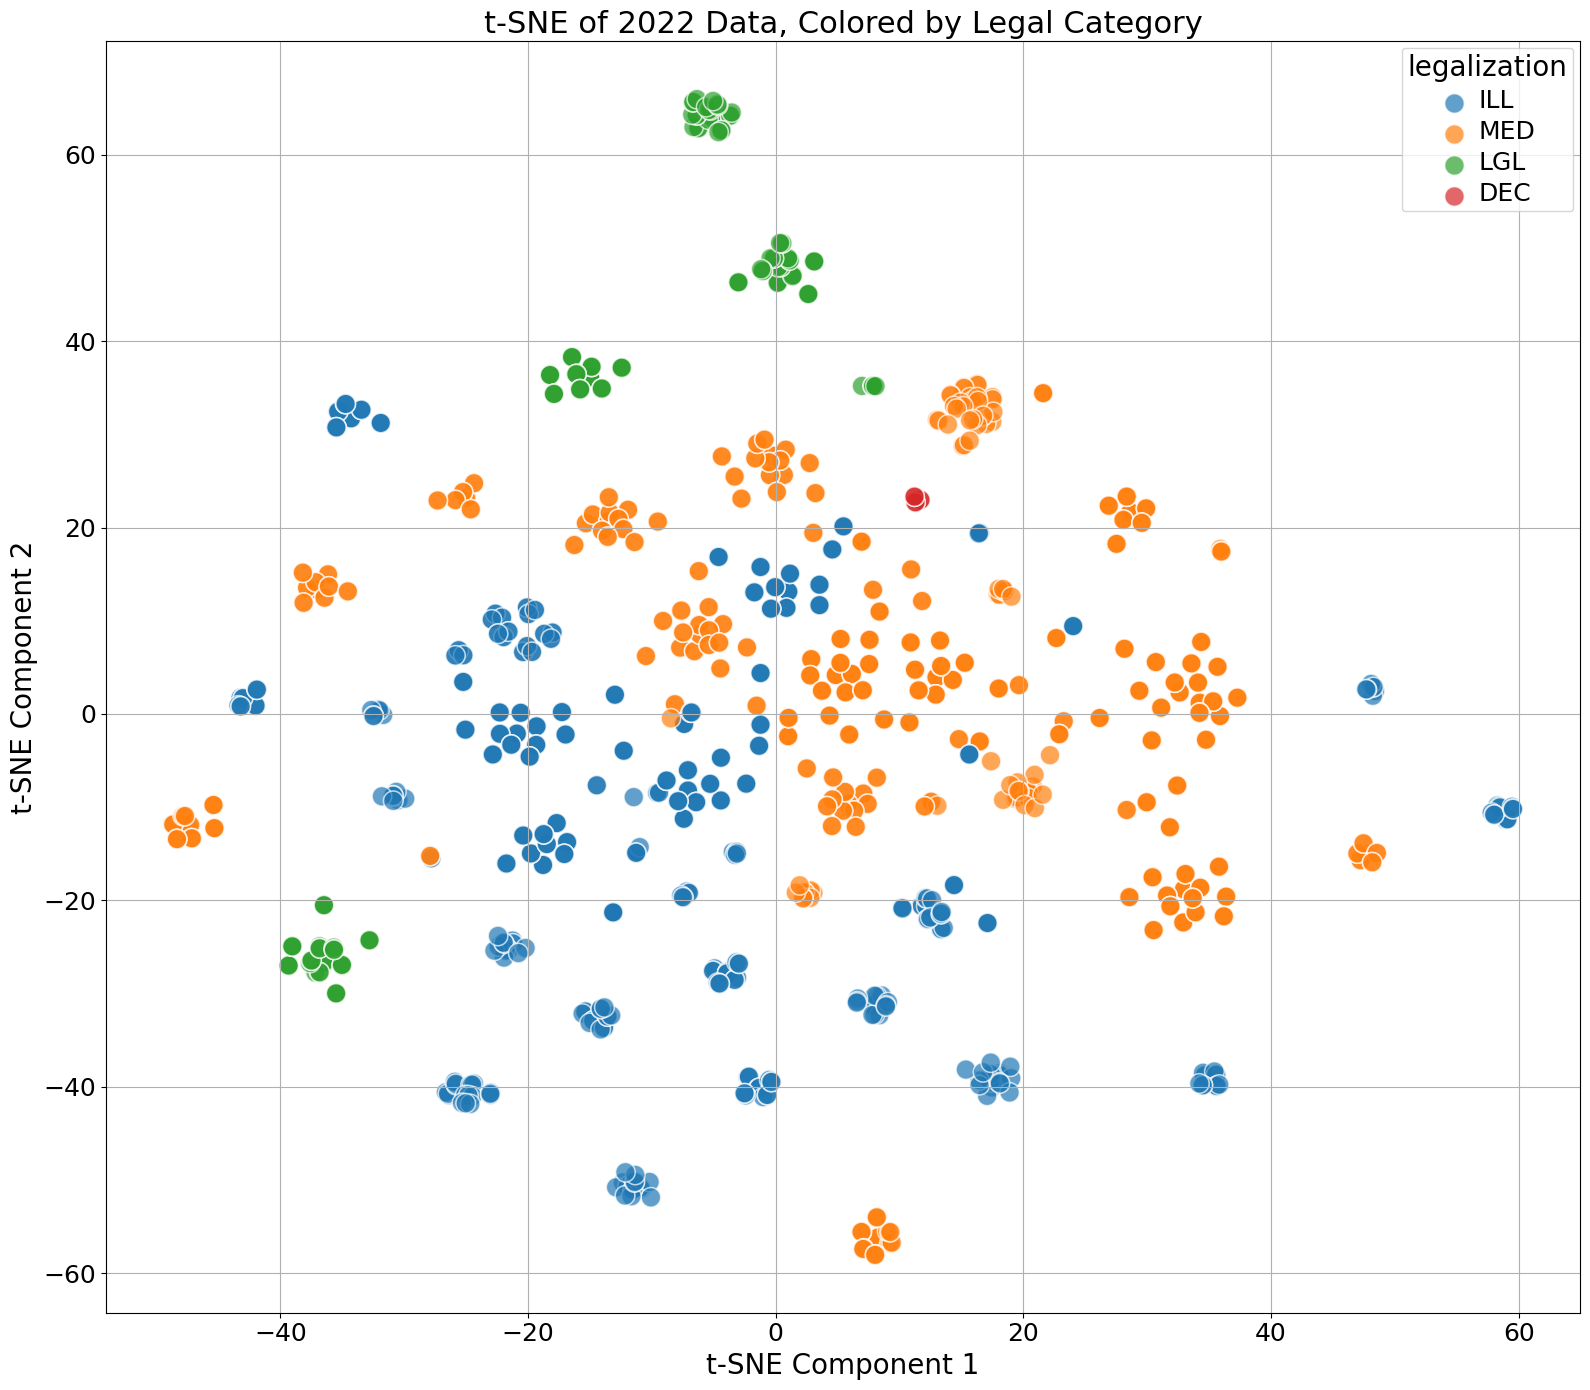

In [54]:
tsne_legal_cat_df = dputil.prep_data_for_tsne(merged_df, filtering_query='seizure_reference_year == 2022', numerical_imputation='median', categorical_imputation='most_frequent')
vis_utils.plot_tsne(tsne_legal_cat_df, merged_df.query('seizure_reference_year == 2022')['legal_category'], title="t-SNE of 2022 Data, Colored by Legal Category", legend_title='legalization', perplexity=30, random_state=SEED)

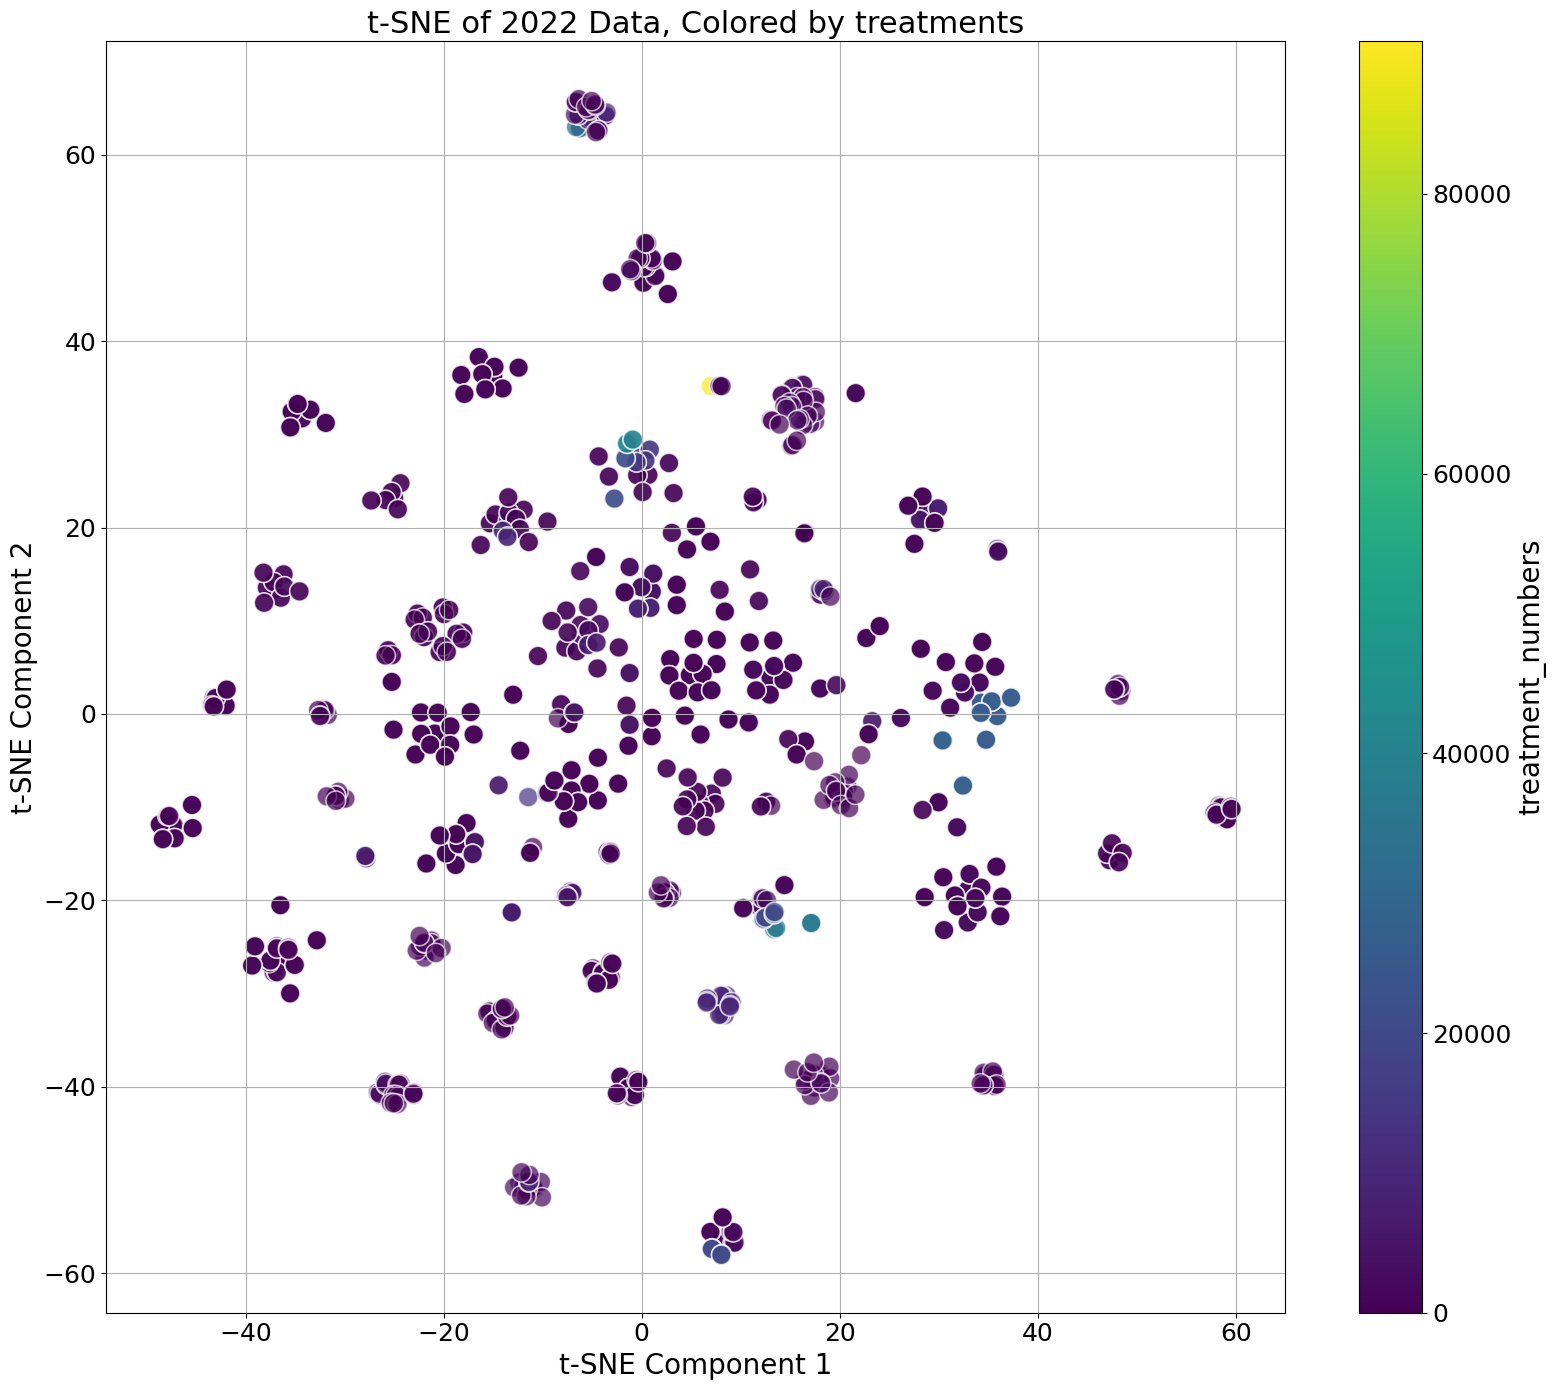

In [55]:
vis_utils.plot_tsne(tsne_legal_cat_df, merged_df.query('seizure_reference_year == 2022')['total_treatments'], title="t-SNE of 2022 Data, Colored by treatments", colorbar=True, legend_title='treatment_numbers', perplexity=30, random_state=SEED)

In [1]:
import random
import pandas as pd
import numpy as np
import os
from pathlib import Path


from utils import vis_utils
import utils.dataset_processing_utils as dputil
from utils.dataset_processing_utils import print_discrepancies

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

#### load the datasets

---

1) Download files:<BR>1.1) From the [UNODC site](https://www.unodc.org/unodc/en/data-and-analysis/wdr2024-annex.html):<BR>
    &emsp;&emsp;1.1.a) 7.1._Drug_seizures_2018-2022.xlsx<BR>
    &emsp;&emsp;1.1.b) 10.1._Drug_related_crimes.xlsx<BR>
    &emsp;&emsp;1.1.c) 5.1_Treatment_by_primary_drug_of_use.xlsx<BR>
    &emsp;1.2) From Kaggle download the [legalization status dataset](https://www.kaggle.com/datasets/venusrosario/legality-of-cannabis/)     <BR>
    &emsp;1.3) Also from Kaggle download the [CIA FactBook data](https://www.kaggle.com/datasets/lucafrance/the-world-factbook-by-cia)     <BR>
    &emsp;1.4) From the WorldBankGroup website, we arranged the collected the data in the timescale we require and exported it into wbg_pop_health_gdp.csv<BR>

2) Change the names for our ease of use:<BR>
    &emsp;2.1) 7.1._Drug_seizures_2018-2022.xlsx --> unodc_drug_seizures.xlsx<BR>
    &emsp;2.2) 10.1._Drug_related_crimes.xlsx --> unodc_drug_crime_counts.xlsx<BR>
    &emsp;2.3) 5.1_Treatment_by_primary_drug_of_use.xlsx --> unodc_drug_treatment.xlsx<BR>
    &emsp;2.3) Legality_of_cannabis.csv --> legalization.csv<BR>

3) Manual feature engineering - further explanation in [here](#manual-feature-engineering)

4) Load data into pandas Dataframes


In [2]:
# Defining constants
if os.name == 'nt':  # in case of MS Windows
    data_path = Path(f"{os.getcwd()}\\data\\")
else:  # Linux or Mac
    data_path = Path(f"{os.getcwd()}/data/")

# rename dataset files
dputil.rename_original_dataset_files(data_path)


In [3]:
# load into pandas DataFrame:
seizures_df = dputil.load_dataset('unodc_drug_seizures.xlsx')
seizures_df.head()

,Region,SubRegion,Country,DrugGroup,DrugSubGroup,DrugName,Reference year,Kilograms,msCode
0,Africa,East Africa,Kenya,Amphetamine-type stimulants (excluding “ecstasy”),Methamphetamine,Methamphetamine,2022,10.84,KEN
1,Africa,East Africa,Kenya,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),Cannabis herb (marijuana),2022,8474.41,KEN
2,Africa,East Africa,Kenya,Cannabis-type drugs (excluding synthetic canna...,Cannabis plants,Cannabis plants,2022,2534.40,KEN
3,Africa,East Africa,Kenya,Cocaine-type,Cocaine,Cocaine hydrochloride,2022,10.99,KEN
4,Africa,East Africa,Kenya,Opioids,Opiates,Heroin,2022,38.94,KEN


In [4]:
crime_counts_df = dputil.load_dataset('unodc_drug_crime_counts.xlsx')
crime_counts_df.head()

,Africa,West and Central Africa,Ghana,ARQ2021,2021,Other drug-related offences,Any Illicit drugs,0,Unnamed: 8,Unnamed: 9,Unnamed: 10,0.1,0.2,Unnamed: 13,Unnamed: 14,Yes,Yes.1,GHA
0,Europe,Western and Central Europe,Gibraltar,ARQ2021,2021,Other drug-related offences,Any Illicit drugs,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,GIB
1,Asia,East and South-East Asia,"China, Macao SAR",ARQ2021,2021,Other drug-related offences,Any Illicit drugs,0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,Yes,Yes,MAC
2,Americas,South America,Venezuela (Bolivarian Republic of),ARQ2022,2022,Other drug-related offences,Any Illicit drugs,0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,Yes,Yes,VEN
3,Africa,North Africa,Algeria,HIST2018,2018,Offences related to drug trafficking,Other opioids not under international control,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Yes,DZA
4,Europe,Western and Central Europe,Gibraltar,ARQ2020,2020,Other drug-related offences,Any Illicit drugs,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Yes,Yes,GIB


In [5]:
treatments_df = dputil.load_dataset('unodc_drug_treatment.xlsx')
treatments_df.head()

,Region,SubRegion,Country,msCode,Reference year,DrugGroup,Drug,Sex,Value,Campaign,Coverage
0,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamines (amphetamine/methamphetamine),Females,2,ARQ2021,NaN
1,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamines (amphetamine/methamphetamine),Males,2,ARQ2021,NaN
2,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamines (amphetamine/methamphetamine),Total,4,ARQ2021,NaN
3,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamine-type stimulants,Females,8,ARQ2021,NaN
4,Africa,East Africa,Kenya,KEN,2021,Amphetamine-type stimulants,Amphetamine-type stimulants,Males,81,ARQ2021,NaN


In [6]:
legalization_df = dputil.load_dataset('legalization.csv', encoding='utf-16')
legalization_df.head()

,Country/Territory,Recreational,Recreational_year,Medical,Mediacal_year,Decriminalized_max_possession,Notes
0,Afghanistan,Illegal,NaN,Illegal,NaN,NaN,Production banned by King Zahir Shah in 1973.
1,Albania,Illegal,NaN,Legal,2023.0,NaN,Prohibited but plants highly available through...
2,Algeria,Illegal,NaN,Illegal,NaN,NaN,NaN
3,Andorra,Illegal,NaN,Illegal,NaN,NaN,NaN
4,Angola,Illegal,NaN,Illegal,NaN,NaN,NaN


In [7]:
borders_df = dputil.load_dataset('cia_factbook.csv', encoding='utf-8')
borders_df.head()

,Country,Geography: Land boundaries - total,Geography: Coastline
0,Afghanistan,"5,987 km",0 km (landlocked)
1,Akrotiri,NaN,NaN
2,Albania,691 km,362 km
3,Algeria,"6,734 km",998 km
4,American Samoa,0 km,116 km


In [8]:
demographics_df = dputil.load_dataset('wbg_pop_health_gdp.csv', encoding='latin-1')
demographics_df.head()

,Country Name,Country Code,Series Name,Series Code,2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024],Unnamed: 12,Unnamed: 13
0,Afghanistan,AFG,"Population, total",SP.POP.TOTL,35688935,36743039,37856121,39068979,40000412,40578842,41454761,..,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,18753456498,18053222687,18799444490,19955929052,14259995441,14497243872,17233051620,..,NaN,NaN
2,Afghanistan,AFG,Current health expenditure (% of GDP),SH.XPD.CHEX.GD.ZS,12.62081718,14.20841885,14.83131981,15.53361416,21.508461,23.0881691,..,..,NaN,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,2873457,2866376,2854191,2837849,2811666,2777689,2745972,..,NaN,NaN
4,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,13019726212,15379509892,15585105131,15241458745,18032010564,19017242586,23547179830,..,NaN,NaN


---

## Manual feature engineering
### legalization.csv

There was crucial information missing - the years when legislation had changed.
Therefore, using the **Notes** column, which contains diverse information, including years when countries changed legislation.
Additionally, it contains data about the maximum amount of cannabis that a citizen can have on his possession without receiving a penalty (in grams).

As such, we manually had created three new columns - *Recreational_year* (integer) and *Medical_year* (integer) which indicate the year the legislation
was enacted in, according to of our category, and *Decriminalized_max_possession* (float) that indicates the maximum amount of possession of cannabis on a person is allowed in a country (in grams).

We validated our manual work with reference to other Wikipedia pages and Google's Gemini for further consultation.

---

### cia_factbook.csv

The original CIA FactBook data had contained 980 columns. We have extracted only the necessary columns, which are the country's name, its border and shoreline length. Furthermore, although we hadn't had the time to do so, we would like to in perpetration for the final report convert the textual data for the borders into numerical data by omitting any non-numerical value from it.

---
### Initial analysis of each dataframe

In this section, we run individual data processing notebooks for each dataset. Each notebook contains data processing methods and data analysis.
You're welcome to run and read every notebook to see how the data was processed.

#### _unodc_seizures_
see notebook: `./individual_dataset_notebooks/unodc_seizures.ipynb`

In [ ]:
%%capture
%run ./individual_dataset_notebooks/unodc_seizures.ipynb

#### _unodc_drug_crime_counts_

see notebook: `./individual_dataset_notebooks/unodc_drug_crime_counts.ipynb`

In [ ]:
%%capture
%run ./individual_dataset_notebooks/unodc_drug_crime_counts.ipynb

#### _unodc_treatments_

see notebook: `./individual_dataset_notebooks/unodc_treatments.ipynb`

In [ ]:
%%capture
%run ./individual_dataset_notebooks/legalization.ipynb

#### _wbg_pop_health_gdp_

see notebook: `./individual_dataset_notebooks/wbg_pop_health_gdp.ipynb`

In [ ]:
%%capture
%run ./individual_dataset_notebooks/legalization.ipynb

#### _cia_factbook_

see notebook: `./individual_dataset_notebooks/cia_factbook.ipynb`

In [ ]:
%%capture
%run ./individual_dataset_notebooks/legalization.ipynb

#### _legalization_

see notebook: `./individual_dataset_notebooks/legalization.ipynb`

In [ ]:
%%capture
%run ./individual_dataset_notebooks/legalization.ipynb

---

### Merging dataframes and further analysis

Now that we are done processing each dataset individually, we would want to merge them.

**Combination process**:

1) `legalization_df_sorted` + `final_seizures_df` = `merged_df`

2) `merged_df` += `edited_crime_counts_df`

3) `merged_df` += `edited_treatments_df`

4) `merged_df` += `demographics_df_edited`

5) `merged_df` += `borders_df_edited`

6) Further analysis - potential correlations, splicing etc.

<BR><BR>

---


#### merging *legalization_df_sorted* and *final_seizures_df*

**initial merging process**

In [ ]:
merged_df = final_seizures_df.merge(legalization_df_sorted, on=["country"], how="outer", validate="many_to_one")

Now we'll check the countries what countries didn't align properly:

In [ ]:
merged_df[pd.isna(merged_df['legal_category'])]["country"].unique()

In [ ]:
merged_df.query("seizure_volume.isnull() & legal_category != 'ILL'")["country"].unique()


List of countries/territories that were removed due to missing values:
- <span style="color: #006400;">Aruba (missing legalization status)</span>
- <span style="color: #006400;">Palestine (missing legalization status)</span>
- <font color="green">Bermuda (missing traffic data)</font>
- <font color="green">Dominica (missing traffic data)</font>
- <font color="green">Rwanda (missing traffic data)</font>
- <font color="green">Saint Kitts and Nevis (missing traffic data)</font>
- <font color="green">Saint Lucia (missing traffic data)</font>
- <font color="green">Saint Vincent and the Grenadines (missing traffic data)</font>
- <font color="green">San Marino (missing traffic data)</font>
- <font color="green">Vanuatu (missing traffic data)</font>


Countries that were added to the list after searching their cannabis legality status:
- Gibraltar (ILL)
- Armenia (ILL)


Additionally - we have changed the names of some countries in order to merge the two datasets correctly. We arbitrarily decided to change the names in  *seizure_df*:

| Old name | New name |
| --- | --- |
| Bolivia (Plurinational State of) | Bolivia |
| Brunei Darussalam | Brunei |
| Cabo Verde | Cape Verde |
| China | People's Republic of China (PRC) |
| China, Hong Kong SAR | Hong Kong |
| China, Macau SAR | Macau, SAR of China |
| China, Taiwan Province of China | Taiwan |
| Czechia | Czech Republic |
| Côte d'Ivoire | Ivory Coast |
| Eswatini | Eswatini (Swaziland) |
| Iran (Islamic Republic of) | Iran |
| Lao People's Democratic Republic | Laos |
| Republic of Korea | Korea, South |
| Republic of Moldova | Moldova |
| Russian Federation | Russia |
| Syrian Arab Republic | Syria |
| Timor-Leste | East Timor |
| Türkiye | Turkey |
| United Republic of Tanzania | Tanzania |
| United States of America | United States |
| Venezuela (Bolivarian Republic of) | Venezuela |

In [ ]:
country_names_to_change = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Brunei Darussalam": "Brunei",
    "Cabo Verde": "Cape Verde",
    "China": "People's Republic of China (PRC)",
    "China, Hong Kong SAR": "Hong Kong",
    "China, Macau SAR": "Macau, SAR of China",
    "China, Macao SAR": "Macau, SAR of China",  # there are 2 variations
    "China, Taiwan Province of China": "Taiwan",
    "Czechia": "Czech Republic",
    "Côte d'Ivoire": "Ivory Coast",
    "Eswatini": "Eswatini (Swaziland)",
    "Holy See": "Vatican City",
    "Iran (Islamic Republic of)": "Iran",
    "Lao People's Democratic Republic": "Laos",
    "Republic of Korea": "Korea, South",
    "Republic of Moldova": "Moldova",
    "Russian Federation": "Russia",
    "Syrian Arab Republic": "Syria",
    "Timor-Leste": "East Timor",
    "Türkiye": "Turkey",
    "United Republic of Tanzania": "Tanzania",
    "United States of America": "United States",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Viet Nam": "Vietnam"
}

In [ ]:
final_seizures_df['country'] = final_seizures_df['country'].replace(country_names_to_change)

rows_to_add_to_legalization_df = [
    {"country": "Armenia", "legal_category": "ILL"},
    {"country": "Gibraltar", "legal_category": "ILL"},
]

legalization_df_sorted = pd.concat([legalization_df_sorted, pd.DataFrame(data=rows_to_add_to_legalization_df, columns=legalization_df_sorted.columns)], ignore_index=True)

Repeating the merge sequence after our changes. By using an inner join matching mechanism, we remove all territories with missing information as mentioned above.

In [ ]:
merged_df = final_seizures_df.merge(legalization_df_sorted, on=["country"], how="inner")
merged_df.sample(10, random_state=SEED).sort_values("legal_category")

---

#### adding *edited_crime_counts_df*

**analyze difference in columns before merge**

In [ ]:
edited_crime_counts_df.columns

In [ ]:
merged_df.columns

In [ ]:
# region:
dputil.print_discrepancies(merged_df, edited_crime_counts_df, "region", "region")

In [ ]:
# country:
dputil.print_discrepancies(merged_df, edited_crime_counts_df, "country", "country")

In [ ]:
# fix discrepancies in country names
crime_counts_df_for_merge = edited_crime_counts_df.copy()
crime_counts_df_for_merge['country'] = crime_counts_df_for_merge['country'].replace(country_names_to_change)


In [ ]:
# year
dputil.print_discrepancies(merged_df, edited_crime_counts_df, "seizure_reference_year", "year")

In [ ]:
# drug_group
dputil.print_discrepancies(merged_df, edited_crime_counts_df, "drug_group", "drug_group")

Since there are too many discrepancies, we will check for the possibility of removing all `drug_group` that are not `Any Illict Drug` which exists for all countries in all years:

In [ ]:
drug_group_instances = {}
for country_year, group in edited_crime_counts_df.groupby(['country', 'year']):
    for drug_group in group['drug_group'].unique():
        if drug_group not in drug_group_instances:
            drug_group_instances[drug_group] = 1
        else:
            drug_group_instances[drug_group] += 1

drug_group_instances = dict(sorted(drug_group_instances.items(), key=lambda x: x[1], reverse=True))

vis_utils.plot_regular_barplot(list(drug_group_instances.keys()), list(drug_group_instances.values()),
                               title="Crime counts 'drug_group' counts", xlabel="drug type", ylabel="number of instances in the dataset", color='green', xticks_rotation=80, figsize=(8, 3), xticks_fontsize=8
                               )

as we can see from the barchart above, even the 2nd highest value after *Any Illicit Drugs* - *Cannabis Type*, is far less abundant than what is required to merge the datasets correctly. Therefore, we will now filter out all non *Any Illicit Drugs* category, and remove the feature.

Additionally, we will re

#### merge dataframes

In [ ]:
crime_counts_df_for_merge = crime_counts_df_for_merge[edited_crime_counts_df['drug_group'] == 'Any Illicit drugs']
crime_counts_df_for_merge.drop(columns=['drug_group', 'sub_region'], inplace=True)
crime_counts_df_for_merge = crime_counts_df_for_merge.rename(columns={"year": "drug_crime_ref_year",
                                                                "calculated_total": "total_crime_cases"})

In [ ]:
merged_df = pd.merge(merged_df, crime_counts_df_for_merge, how="left", left_on=["region", "country", "seizure_reference_year"], right_on=["region", "country", "drug_crime_ref_year"])
merged_df = merged_df.drop(columns=["drug_crime_ref_year"])

---

#### adding *treatments_df*

**analyze difference in columns before merge**

In [ ]:
print(f"{'*'*22}  merged_df  {'*'*22}", merged_df.columns)
print(f"{'*'*22}  treatments_df  {'*'*22}", edited_treatments_df.columns)

Check for discrepancies in the following columns:
- country
- drug_group
- drug_sub_group

In [ ]:
dputil.print_discrepancies(merged_df, edited_treatments_df, "country", "country")

In [ ]:
 # fix discrepancies in country names
treatments_df_for_merge = edited_treatments_df.copy()
treatments_df_for_merge['country'] = treatments_df_for_merge['country'].replace(country_names_to_change)

In [ ]:
dputil.print_discrepancies(merged_df, treatments_df_for_merge, "country", "country")

In [ ]:
missing_countries_in_treatments = {'Maldives', 'Jamaica', 'Paraguay', 'India', 'Syria', 'Barbados', 'Sudan', 'Canada', 'Japan', 'Cameroon', 'Guyana', 'Liberia', 'Belize', 'East Timor', 'Bahrain', 'Korea, South', 'Gambia', 'Pakistan', 'Afghanistan', 'Eswatini (Swaziland)', 'Israel', 'Vietnam', 'Bhutan', 'Namibia', 'Taiwan', 'Kuwait', 'Guinea-Bissau', 'Dominican Republic', 'Iceland', 'Qatar', 'Chad', 'Bolivia'}
merged_df.query("country in @missing_countries_in_treatments")[["country", "legal_category"]].drop_duplicates()["legal_category"].value_counts()

However unfortunate, we are unable to apply models and further analyses on the countries above, since we are missing our target variable.

In [ ]:
dputil.print_discrepancies(merged_df, treatments_df_for_merge, "drug_group", "drug_group")

In [ ]:
# align drug_group between treatments and the merged data:
drug_group_mapping_treatments = {
    'Cocaine-type drugs': 'Cocaine-type',
    'Amphetamine-type stimulants': 'Amphetamine-type stimulants (excluding “ecstasy”)',
    'Non-medical use of pharmaceutical sedatives and tranquillizers': 'Sedatives and tranquillizers',
    'Opioids, including opiates and synthetic opioids': 'Opioids',
    'Cannabis-type drugs': 'Cannabis-type drugs (excluding synthetic cannabinoids)',
    'New psychoactive substances': np.nan,
    'Non-specified': np.nan,
    'Other drugs / psychoactive substances / pharmaceutical products not listed above': np.nan,
    'Solvents and inhalants': np.nan,
    'Other miscellaneous': np.nan,
    'Any drug': np.nan,
    'Substances not under international control': np.nan
}

treatments_df_for_merge['drug_group'] = treatments_df_for_merge['drug_group'].replace(drug_group_mapping_treatments)
treatments_df_for_merge = treatments_df_for_merge.dropna(subset=['drug_group'])
treatments_df_for_merge = treatments_df_for_merge.rename(columns={"gender_ratio": "patient_gender_ratio"})

In [ ]:
merged_df = pd.merge(merged_df, treatments_df_for_merge, how="inner", left_on=["country", "seizure_reference_year", "drug_group"], right_on=["country", "year", "drug_group"])
merged_df = merged_df.drop(columns=["year"])

#### Merging demographics data

In [ ]:
pivoted_demographics_df.columns

In [ ]:
dputil.print_discrepancies(merged_df, pivoted_demographics_df, "country", "country")

In [ ]:
demographics_df_for_merge = pivoted_demographics_df.copy()
demographics_df_for_merge["country"] = demographics_df_for_merge["country"].replace(country_names_to_change)
dputil.print_discrepancies(merged_df, demographics_df_for_merge, "country", "country")

In [ ]:
update_country_dict = {
    'Macao SAR, China': 'Macau, SAR of China',
    'Hong Kong SAR, China': 'Hong Kong',
    'Turkiye': 'Turkey',
    'Slovak Republic': 'Slovakia',
    'Egypt, Arab Rep.': 'Egypt',
    'Venezuela, RB': 'Venezuela',
}
demographics_df_for_merge["country"] = demographics_df_for_merge["country"].replace(update_country_dict)

In [ ]:
print_discrepancies(merged_df, demographics_df_for_merge, "seizure_reference_year", "year")

In [ ]:
demographics_df_for_merge = demographics_df_for_merge.drop(columns=["Country Code"])

In [ ]:
merged_df = pd.merge(merged_df, demographics_df_for_merge, how="left", left_on=["country", "seizure_reference_year"], right_on=["country", "year"], suffixes=["", "_to_remove"])
merged_df = merged_df.drop(columns=["year"])

#### merging borders data

In [ ]:
# borders_df_edited.columns

In [ ]:
print_discrepancies(merged_df, borders_df_edited, "country", "country")

In [ ]:
border_df_for_merge = borders_df_edited.copy()
country_names_to_change.update({
    "Czechia": "Czech Republic",
    "China": "People's Republic of China (PRC)",
    "Burma": "Myanmar",
    "Turkey (Turkiye)": "Turkey",
    "Macau": "Macau, SAR of China",
    "Bahamas, The": "Bahamas"
})
border_df_for_merge["country"] = border_df_for_merge["country"].replace(country_names_to_change)
print_discrepancies(merged_df, border_df_for_merge, "country", "country")

In [ ]:
merged_df = pd.merge(merged_df, border_df_for_merge, how="left", left_on=["country"], right_on=["country"])

### The final dataset, after preprocessing:

#### Dimensions: 5094x21

In [ ]:
merged_df

In [ ]:
merged_df.describe()

In [ ]:
merged_df.describe(include='object')

In [ ]:
merged_df.to_csv("data/final_dataframe.csv", index=False)

## Additional EDA:
#### 1. Representation in 2D space
#### 2. Correlations

The representation will be represented using tSNE

In [ ]:
tsne_legal_cat_df = dputil.prep_data_for_tsne(merged_df, filtering_query='seizure_reference_year == 2022', numerical_imputation='median', categorical_imputation='most_frequent')
vis_utils.plot_tsne(tsne_legal_cat_df, merged_df.query('seizure_reference_year == 2022')['legal_category'], title="t-SNE of 2022 Data, Colored by Legal Category", legend_title='legalization', perplexity=30, random_state=SEED)

In [ ]:
vis_utils.plot_tsne(tsne_legal_cat_df, merged_df.query('seizure_reference_year == 2022')['total_treatments'], title="t-SNE of 2022 Data, Colored by treatments", colorbar=True, legend_title='treatment_numbers', perplexity=30, random_state=SEED)